## Set Datasets

In [331]:
from sklearn import datasets
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load the cancer dataset
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# Shuffle the dataset
np.random.seed(43)
shuffled_indices = np.random.permutation(X.shape[0])
X = X[shuffled_indices]
y = y[shuffled_indices]

# PCA
pca = PCA(n_components=4)
X = pca.fit_transform(X)

# Scale Minmaxscaler to [0, π]
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X = scaler.fit_transform(X)


# Select 100 samples from each class (class 0, 1)
samples_per_class = 100
selected_indices = np.hstack([
    np.where(y == class_idx)[0][:samples_per_class] for class_idx in range(2)
])

X_selected = X[selected_indices]
y_selected = y[selected_indices]

print(f"Selected X shape: {X_selected.shape}")
print(f"Selected y shape: {y_selected.shape}")


# Take 16 samples per class for training
train_samples_per_class = 32
train_indices = np.hstack([
    np.where(y_selected == class_idx)[0][:train_samples_per_class] for class_idx in range(2)
])

X_train = X_selected[train_indices]
y_train = y_selected[train_indices]
y_train = np.where(y_train == 0, -1, 1)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

# Split the remaining data into testing sets
# Get the indices of the remaining samples (not used for training)
remaining_indices = np.setdiff1d(np.arange(X_selected.shape[0]), train_indices)

X_test = X_selected[remaining_indices]
y_test = y_selected[remaining_indices]


print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")




Selected X shape: (200, 4)
Selected y shape: (200,)
Training X shape: (64, 4)
Training y shape: (64,)
Test X shape: (136, 4)
Test y shape: (136,)


## 2. Create Trainable Quantum Feature Map (TQFM)

In [332]:
#!/usr/bin/env python3
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

# Reload the module to get the latest changes
import importlib
import src.feature_map
importlib.reload(src.feature_map)
from src.feature_map import TrainableQuantumFeatureMap

depth = 4
tqfm = TrainableQuantumFeatureMap(depth=depth, optimizer='COBYLA', maxiter=200)
tqfm.fit(X_train, y_train)

Current loss: 0.4538413499135303
Current loss: 0.4539506576043211
Current loss: 0.4704692808301505
Current loss: 0.4726019981334698
Current loss: 0.5502307562842319
Current loss: 0.47593478173265613
Current loss: 0.4737704157053454
Current loss: 0.4535111104239724
Current loss: 0.45001297726919454
Current loss: 0.43915574357351894
Current loss: 0.475086195205047
Current loss: 0.42049354220154134
Current loss: 0.4496899456192751
Current loss: 0.45145702319425407
Current loss: 0.4217438134121253
Current loss: 0.4477097943991817
Current loss: 0.454967928412106
Current loss: 0.4204935422015412
Current loss: 0.42049354220154145
Current loss: 0.42049354220154145
Current loss: 0.4032314629707927
Current loss: 0.5005376420803079
Current loss: 0.39341095125878045
Current loss: 0.3701942812643183
Current loss: 0.3584357294173399
Current loss: 0.34962477201749453
Current loss: 0.46328662089332684
Current loss: 0.36140017216524867
Current loss: 0.34784353104000476
Current loss: 0.39994020213695847

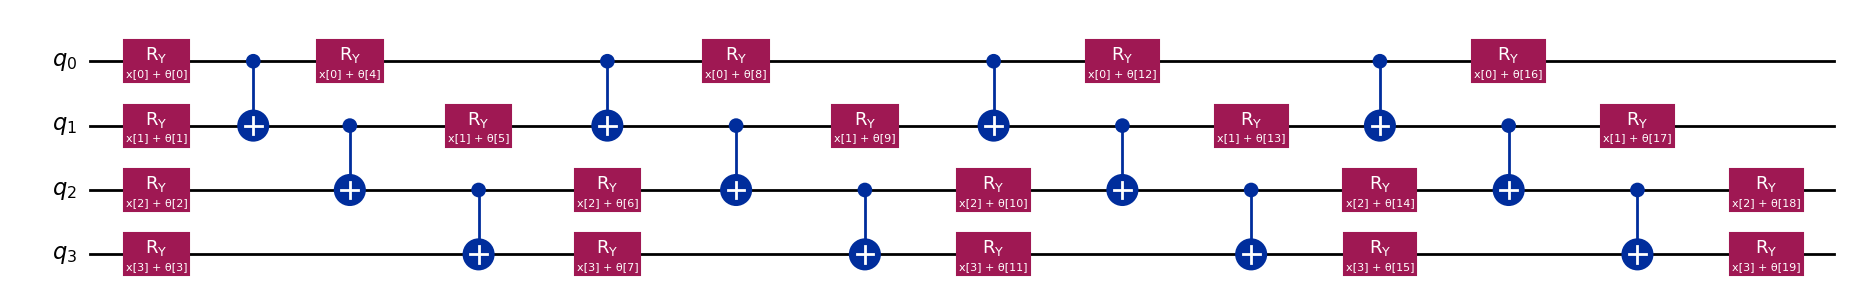

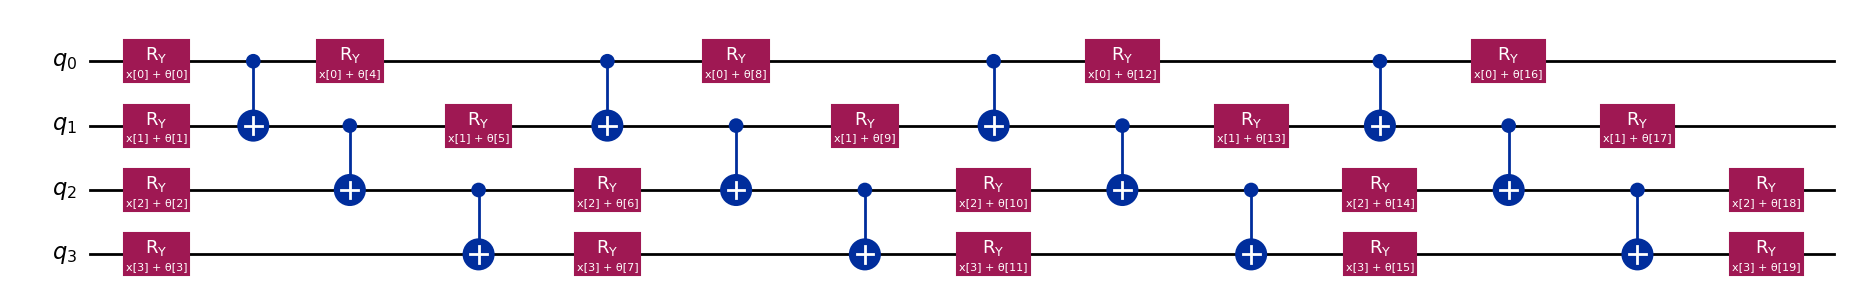

In [315]:
# print circuit
tqfm.circuit.draw("mpl", fold=-1)

In [316]:
print("Optimal parameters:", tqfm.get_optimal_params())
print("Optimal value:", tqfm.get_optimal_value())

Optimal parameters: [1.75525226 2.83199097 4.2642529  7.24896089 4.70622951 0.64540321
 6.19082166 6.0469064  5.73946131 6.13229204 3.79959736 6.86135494
 3.45332833 2.37605589 3.81483323 4.28519003 5.65200467 2.64169207
 6.49696178 2.4233078 ]
Optimal value: 0.23723904928029138


In [317]:
print(tqfm.optimal_params)

[1.75525226 2.83199097 4.2642529  7.24896089 4.70622951 0.64540321
 6.19082166 6.0469064  5.73946131 6.13229204 3.79959736 6.86135494
 3.45332833 2.37605589 3.81483323 4.28519003 5.65200467 2.64169207
 6.49696178 2.4233078 ]


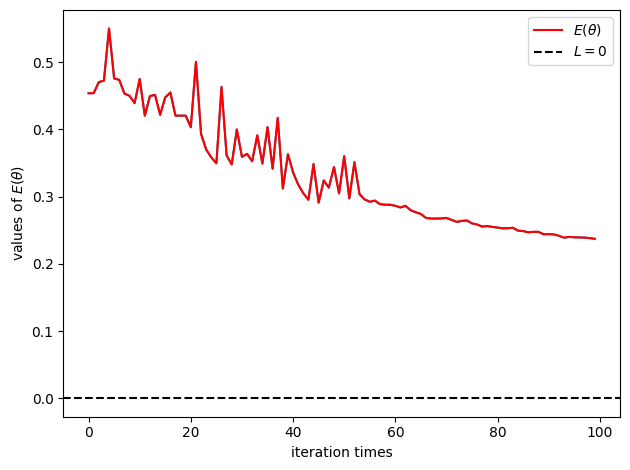

In [333]:
# Plot the loss history
tqfm.plot_loss()

## 3. Kernel Matrix

In [334]:
import importlib
import src.kernel
importlib.reload(src.kernel)
from src.kernel import QuantumKernel

qkernel = QuantumKernel()

kernel_before = qkernel.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.init_theta, tqfm.circuit)
kernel_after = qkernel.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.optimal_params, tqfm.circuit)


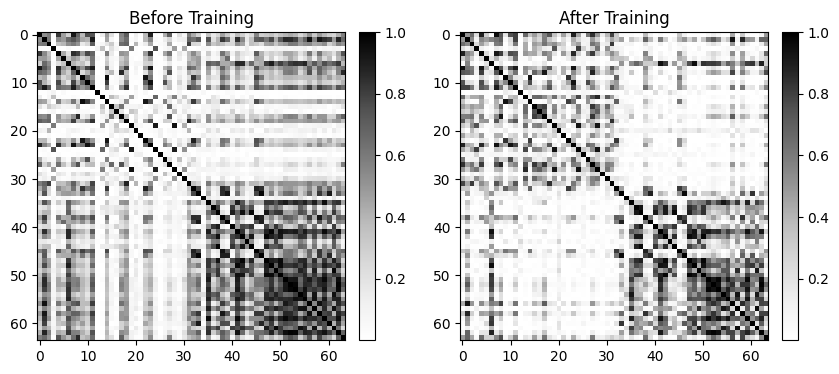

In [335]:
qkernel.plot_multi_kernel_matrices(matrices= [kernel_before, kernel_after], titles= ["Before Training", "After Training"])

## 4. Decomposing


In [321]:
K = np.zeros_like(kernel_after)

for i in range(kernel_after.shape[0]):
    for j in range(kernel_after.shape[1]):
        K[i, j] = y_train[i] * y_train[j] * kernel_after[i, j] + (1 if i == j else 0) / 1  # Assuming gamma=0.1


In [322]:
import importlib
import src.decompose
importlib.reload(src.decompose)
from src.decompose import Decomposer

decomposer = Decomposer()

hamiltonian = decomposer.decompose(K, random=False)
print(hamiltonian)

SparsePauliOp(['IIIIII', 'IIIIIX', 'IIIIZX', 'IIIZIX', 'IIIZZX', 'IIZIIX', 'IIZIZX', 'IIZZIX', 'IIZZZX', 'IZIIIX', 'IZIIZX', 'IZIZIX', 'IZIZZX', 'IZZIIX', 'IZZIZX', 'IZZZIX', 'IZZZZX', 'ZIIIIX', 'ZIIIZX', 'ZIIZIX', 'ZIIZZX', 'ZIZIIX', 'ZIZIZX', 'ZIZZIX', 'ZIZZZX', 'ZZIIIX', 'ZZIIZX', 'ZZIZIX', 'ZZIZZX', 'ZZZIIX', 'ZZZIZX', 'ZZZZIX', 'ZZZZZX', 'IIIIXI', 'IIIIXZ', 'IIIZXI', 'IIIZXZ', 'IIZIXI', 'IIZIXZ', 'IIZZXI', 'IIZZXZ', 'IZIIXI', 'IZIIXZ', 'IZIZXI', 'IZIZXZ', 'IZZIXI', 'IZZIXZ', 'IZZZXI', 'IZZZXZ', 'ZIIIXI', 'ZIIIXZ', 'ZIIZXI', 'ZIIZXZ', 'ZIZIXI', 'ZIZIXZ', 'ZIZZXI', 'ZIZZXZ', 'ZZIIXI', 'ZZIIXZ', 'ZZIZXI', 'ZZIZXZ', 'ZZZIXI', 'ZZZIXZ', 'ZZZZXI', 'ZZZZXZ', 'IIIIXX', 'IIIIYY', 'IIIZXX', 'IIIZYY', 'IIZIXX', 'IIZIYY', 'IIZZXX', 'IIZZYY', 'IZIIXX', 'IZIIYY', 'IZIZXX', 'IZIZYY', 'IZZIXX', 'IZZIYY', 'IZZZXX', 'IZZZYY', 'ZIIIXX', 'ZIIIYY', 'ZIIZXX', 'ZIIZYY', 'ZIZIXX', 'ZIZIYY', 'ZIZZXX', 'ZIZZYY', 'ZZIIXX', 'ZZIIYY', 'ZZIZXX', 'ZZIZYY', 'ZZZIXX', 'ZZZIYY', 'ZZZZXX', 'ZZZZYY', 'IIIXII', 'IIIX

## 5. Trainning


In [323]:
import importlib
import src.qsvm
importlib.reload(src.qsvm)
from src.qsvm import QSVC

qsvc = QSVC(C=1.0, optimizer='COBYLA', max_iter=100)
qsvc.fit(X=X_train,
         y=y_train,
         hamiltonian=hamiltonian,
         theta_optimal=tqfm.optimal_params,
         parametrized_circuit=tqfm.circuit)


Iteration 1: Loss = 1.6093518389516213
Iteration 2: Loss = 8.717866015649644
Iteration 3: Loss = 1.5101554888645126
Iteration 4: Loss = 1.6429074855256536
Iteration 5: Loss = 1.4022916407990915
Iteration 6: Loss = 2.864242485977295
Iteration 7: Loss = 5.343796512615742
Iteration 8: Loss = 4.2895820350766805
Iteration 9: Loss = 0.41671519388482714
Iteration 10: Loss = 2.7661318858695276
Iteration 11: Loss = 1.356970490688994
Iteration 12: Loss = 0.01779262508088808
Iteration 13: Loss = -0.20987199730655215
Iteration 14: Loss = 2.572742729950079
Iteration 15: Loss = 0.044262834664683726
Iteration 16: Loss = -0.30822325513842574
Iteration 17: Loss = -0.4304605080104309
Iteration 18: Loss = 0.21752290463072843
Iteration 19: Loss = 0.1776366637335608
Iteration 20: Loss = 0.12053214332473516
Iteration 21: Loss = -0.37073107942105843
Iteration 22: Loss = 0.07220708836477119
Iteration 23: Loss = -0.2053606206301377
Iteration 24: Loss = -0.4819581493915117
Iteration 25: Loss = -0.43671327300310

In [324]:
print("Optimal value:", qsvc.optimal_value)
print("Optimal parameters:", qsvc.optimal_params)

Optimal value: -0.7900391606943084
Optimal parameters: [2.81833372 5.05901201 5.8549089  6.31240793 5.42255434 5.42855647
 1.70734621 4.11008035 1.19798476]


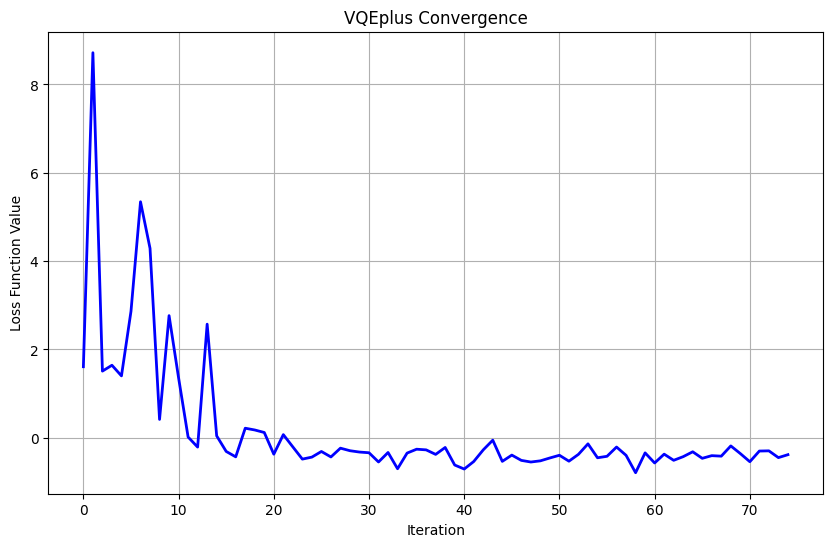

In [325]:
# Plot the loss history
qsvc.plot_convergence()

Measurement results at ξ*: {'010000': 72, '001010': 5, '111111': 33, '100001': 603, '100111': 33, '000100': 6, '101101': 109, '110011': 48, '010101': 70, '101100': 34, '000011': 90, '100000': 297, '111001': 40, '101010': 51, '110110': 36, '000001': 321, '101000': 51, '111110': 10, '100010': 98, '011010': 65, '101001': 71, '000110': 49, '101111': 74, '110001': 188, '110010': 31, '000101': 44, '101110': 40, '101011': 7, '110101': 8, '000010': 58, '011011': 61, '000111': 23, '110000': 80, '010111': 29, '010011': 29, '001111': 15, '111010': 24, '100110': 145, '111011': 10, '001110': 15, '100101': 53, '010001': 102, '110111': 6, '000000': 174, '111101': 58, '001100': 11, '100011': 150, '011000': 57, '100100': 4, '111100': 19, '001101': 37, '010110': 87, '011001': 128, '011100': 11, '010100': 9, '001000': 8, '111000': 23, '011101': 38, '011111': 16, '011110': 6, '010010': 22, '001001': 4}


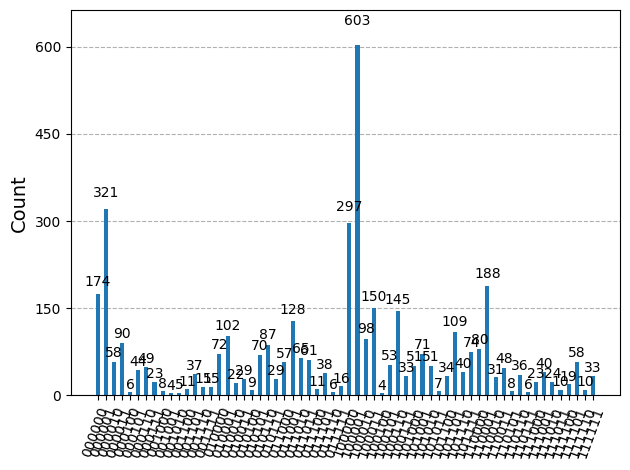

In [326]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit import transpile
# Create ansatz with optimal parameter


ansatz = qsvc.get_ansatz().copy()
ansatz.measure_all()

ansatz = ansatz.assign_parameters({qsvc.ansatz.parameters[i]: qsvc.optimal_params[i] for i in range(len(qsvc.optimal_params))})

# Backend simulator
simulator = AerSimulator()
compiled = transpile(ansatz, simulator)
result = simulator.run(compiled, shots=4096).result()
counts = result.get_counts()

# In histogram
print("Measurement results at ξ*:", counts)
%matplotlib inline
plot_histogram(counts)
plt.show()

In [327]:
print(len(qsvc.support_vectors))

19


In [328]:
accuracy = qsvc.score(X_test, np.where(y_test == 0, -1, 1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 80.88%


In [329]:
from sklearn.svm import SVC


svm2 = SVC(kernel='precomputed', C=1/0.01)
svm2.fit(kernel_after, y_train)

# Use the corrected function that returns (n_test, n_train) directly
kernel_test = qkernel.compute_kernel_matrix_with_inner_products(X_test, X_train, tqfm.optimal_params, tqfm.circuit)

print(f"Training kernel shape: {kernel_after.shape}")
print(f"Test kernel shape (corrected): {kernel_test.shape}")

y_pred_svm2 = svm2.predict(kernel_test)
accuracy_svm2 = np.mean(y_pred_svm2 == np.where(y_test == 0, -1, 1))
print(f"SVM Test set accuracy (corrected): {accuracy_svm2 * 100:.2f}%")

Training kernel shape: (64, 64)
Test kernel shape (corrected): (136, 64)
SVM Test set accuracy (corrected): 91.91%


In [330]:
# 5. Lấy alpha_i
alphas = np.zeros(len(y_train))
support_indices = svm2.support_
dual_coefs = svm2.dual_coef_.ravel()  # = alpha_i * y_i

# Tính alpha_i = dual_coef / y_i
alphas[support_indices] = dual_coefs / y_train[support_indices]

print("Support vector indices:", support_indices)
print("Alpha_i (khác 0 ở support vectors):")
print(alphas)

Support vector indices: [ 1  6  8 12 20 22 29 32 34 36 39 48 56 60 63]
Alpha_i (khác 0 ở support vectors):
[ 0.         22.28328753  0.          0.          0.          0.
 40.63062027  0.         11.30193605  0.          0.          0.
  0.8861167   0.          0.          0.          0.          0.
  0.          0.          3.29722847  0.          4.01095286  0.
  0.          0.          0.          0.          0.          0.27531261
  0.          0.          4.74186599  0.          2.15344002  0.
  1.18720588  0.          0.          3.47835785  0.          0.
  0.          0.          0.          0.          0.          0.
 29.06191391  0.          0.          0.          0.          0.
  0.          0.         36.93041892  0.          0.          0.
  3.69003608  0.          0.          1.44221584]
